In [1]:
from generate_data import generate_data
from gibbs import GibbsSampler
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pickle

# Setup and EDA

## Generate Data Sets

In [2]:
independent_data = generate_data()
correlated_data = generate_data(0.9)

## Plot Mean and Variance Over Time

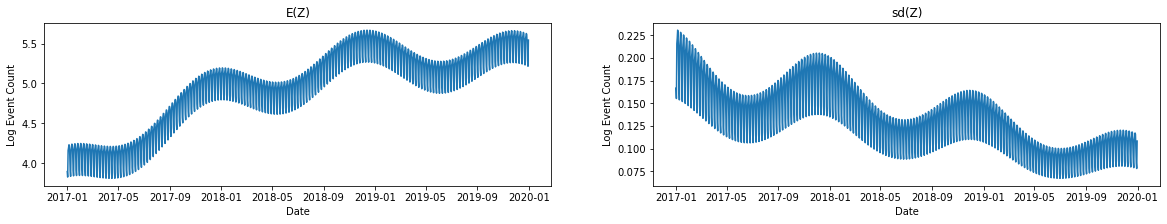

In [94]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 3))

ax1.plot(independent_data.days, independent_data.mu, label="mean")
ax1.set_xlabel("Date")
ax1.set_ylabel("Log Event Count")
ax1.set_title("E(Z)")

ax2.plot(independent_data.days, independent_data.sigma, label="standard deviation")
ax2.set_xlabel("Date")
plt.ylabel("Log Event Count")
ax2.set_title("sd(Z)")

plt.savefig("./figures/mean_var_functions.png")
plt.show()

In [93]:
# The data set is underdispersed
print(np.exp(5))
print(np.sqrt(np.exp(5)))
print(np.exp(0.15))

148.4131591025766
12.182493960703473
1.161834242728283


## Compare Data Sets

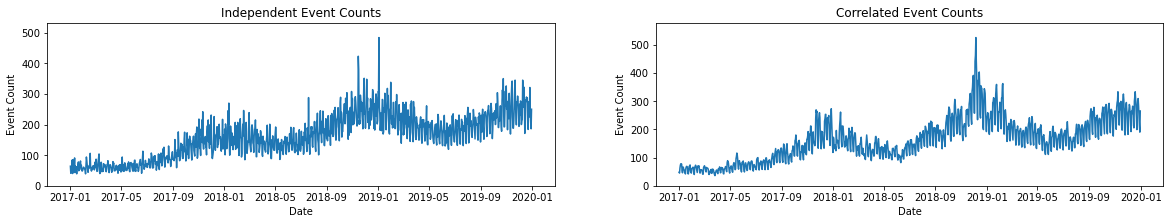

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 3))

ax1.plot(independent_data.days, independent_data.y)
ax1.set_ylim((0, 1.1*np.max(independent_data.y)))
ax1.set_xlabel("Date")
ax1.set_ylabel("Event Count")
ax1.set_title("Independent Event Counts")

ax2.plot(correlated_data.days, correlated_data.y)
ax2.set_ylim((0, 1.1*np.max(correlated_data.y)))
ax2.set_xlabel("Date")
ax2.set_ylabel("Event Count")
ax2.set_title("Correlated Event Counts")

fig.savefig("./figures/events_over_time.png")
plt.show()

# Model-fitting
## Independent Data

In [5]:
gibbs_ind_ind = GibbsSampler()
gibbs_ind_cor = GibbsSampler(alpha_rho=1, beta_rho=1)
n_iter = 2000

In [6]:
gibbs_ind_ind.fit(independent_data, n_iter=n_iter)
pickle.dump(gibbs_ind_ind, open("gibbs_ind_ind.pkl", "wb")) 

In [7]:
gibbs_ind_cor.fit(independent_data, n_iter=n_iter)
pickle.dump(gibbs_ind_cor, open("gibbs_ind_cor.pkl", "wb")) 

## Correlated Data

In [9]:
gibbs_cor_ind = GibbsSampler()
gibbs_cor_cor = GibbsSampler(alpha_rho=1, beta_rho=1)

In [10]:
gibbs_cor_ind.fit(correlated_data, n_iter=n_iter)
pickle.dump(gibbs_cor_ind, open("gibbs_cor_ind.pkl", "wb")) 

In [11]:
gibbs_cor_cor.fit(correlated_data, n_iter=n_iter)
pickle.dump(gibbs_cor_cor, open("gibbs_cor_cor.pkl", "wb")) 

# Analysis

In [100]:
burnin = int(n_iter/4)
n_days = independent_data.days.size

In [101]:
# Function for plotting E(Z) and sd(Z) for two models
def plot_mean_var(mod1, mod2, filename, proportion=1.):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 3))

    first_day_idx = int((1-proportion)*n_days)
    ax1.plot(
        independent_data.days[first_day_idx:],
        independent_data.mu[first_day_idx:],
        label="Truth"
    )
    ax1.plot(
        independent_data.days[first_day_idx:],
        mod1.mu.values[burnin:, first_day_idx:].mean(axis=0),
        label="Independent Model",
#         linestyle="dashed",
    )
    ax1.plot(
        independent_data.days[first_day_idx:],
        mod2.mu.values[burnin:, first_day_idx:].mean(axis=0),
        label="Correlated Model",
#         linestyle="dashdot",
    )

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Event Count")
    ax1.set_title("E(Z)")
    ax1.legend()

    ax2.plot(
        independent_data.days[first_day_idx:],
        independent_data.sigma[first_day_idx:],
        label="Truth"
    )
    ax2.plot(
        independent_data.days[first_day_idx:],
        mod1.sigma.values[burnin:, first_day_idx:].mean(axis=0),
        label="Independent Model",
#         linestyle="dashed",
    )
    ax2.plot(
        independent_data.days[first_day_idx:],
        mod2.sigma.values[burnin:, first_day_idx:].mean(axis=0),
        label="Correlated Model",
#         linestyle="dashdot",
    )
    ax2.set_xlabel("Date")
    plt.ylabel("Event Count")
    ax2.set_title("sd(Z)")
    ax2.legend()

    plt.savefig(filename)
    plt.show()

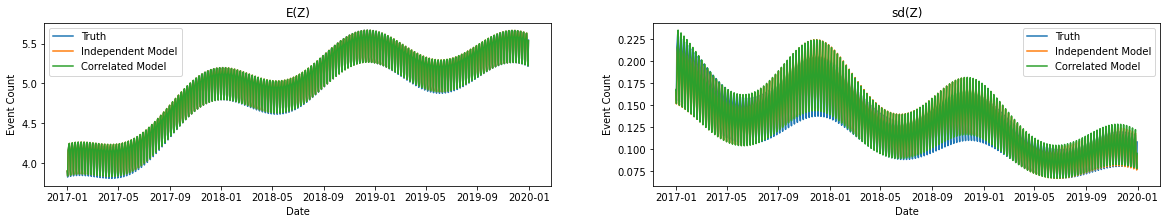

In [102]:
plot_mean_var(gibbs_ind_ind, gibbs_ind_cor, "./figures/ind_data_mean_var.png", proportion=1)

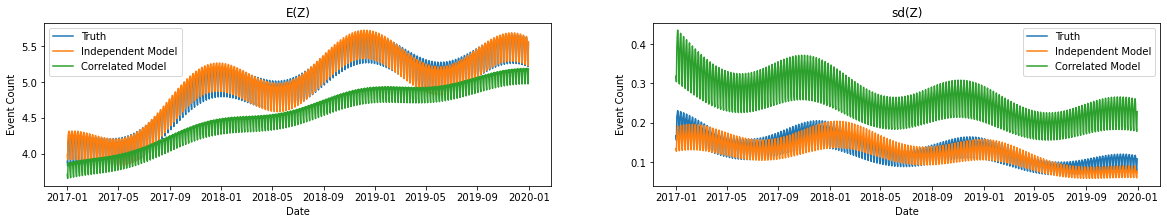

In [103]:
plot_mean_var(gibbs_cor_ind, gibbs_cor_cor, "./figures/cor_data_mean_var.png")

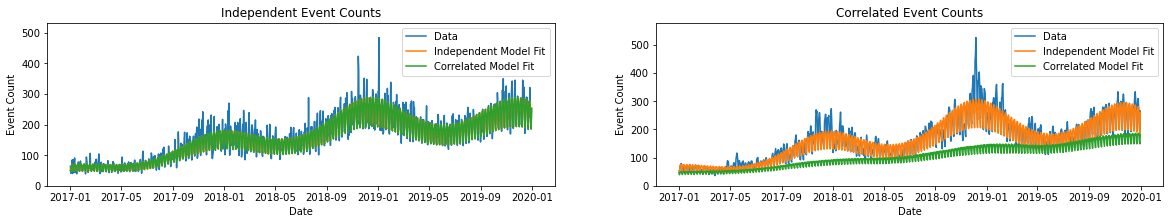

In [119]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 3))

ax1.plot(independent_data.days, independent_data.y, label="Data")
ax1.plot(
    independent_data.days,
    np.exp(np.median(gibbs_ind_ind.mu.values[burnin:, :], axis=0)),
    label="Independent Model Fit",
)
ax1.plot(
    independent_data.days,
    np.exp(np.median(gibbs_ind_cor.mu.values[burnin:, :], axis=0)),
    label="Correlated Model Fit",
)

ax1.set_ylim((0, 1.1*np.max(independent_data.y)))
ax1.set_xlabel("Date")
ax1.set_ylabel("Event Count")
ax1.set_title("Independent Event Counts")
ax1.legend()

ax2.plot(correlated_data.days, correlated_data.y, label="Data")
ax2.plot(
    independent_data.days,
    np.exp(np.median(gibbs_cor_ind.mu.values[burnin:, :], axis=0)),
    label="Independent Model Fit",
)
ax2.plot(
    independent_data.days,
    np.exp(np.median(gibbs_cor_cor.mu.values[burnin:, :], axis=0)),
    label="Correlated Model Fit",
)

ax2.set_ylim((0, 1.1*np.max(correlated_data.y)))
ax2.set_xlabel("Date")
ax2.set_ylabel("Event Count")
ax2.set_title("Correlated Event Counts")
ax2.legend()

fig.savefig("./figures/model_fits.png")
plt.show()

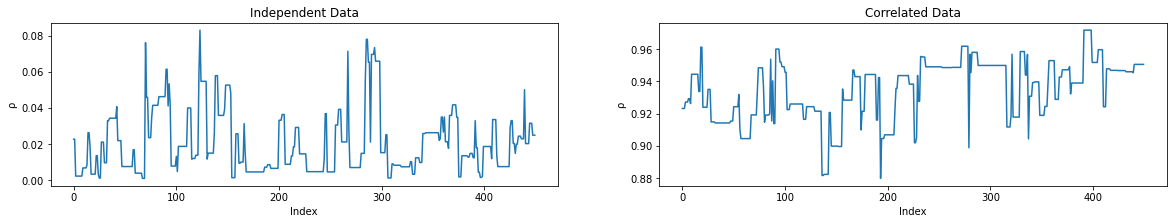

In [131]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 3))
ax1.plot(gibbs_ind_cor.rho.values[burnin:])
ax1.set_xlabel("Index")
ax1.set_ylabel("ρ")
ax1.set_title("Independent Data")

ax2.plot(gibbs_cor_cor.rho.values[burnin:])
ax2.set_xlabel("Index")
ax2.set_ylabel("ρ")
ax2.set_title("Correlated Data")

fig.savefig("./figures/rho_trace_plots.png")
plt.show()

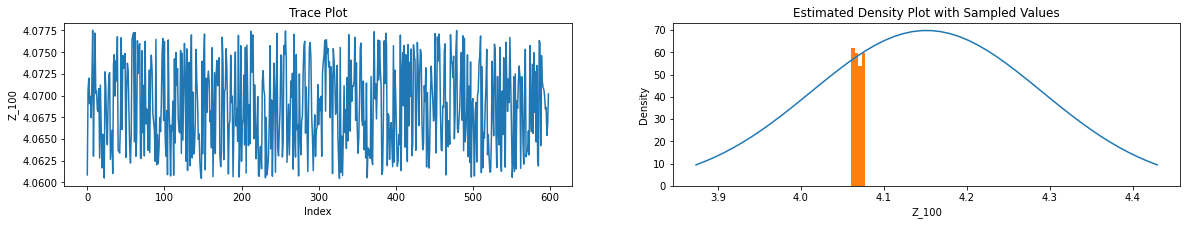

In [201]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 3))
i = 100
ax1.plot(gibbs_ind_ind.z.values[1:, i])
ax1.set_xlabel("Index")
ax1.set_ylabel(f"Z_{i+1}")
ax1.set_title("Trace Plot")

y_i = independent_data.y[i]
mu_i = gibbs_ind_ind.mu.values[burnin:, i].mean()
sigma_i = gibbs_ind_ind.sigma.values[burnin:, i].mean()
z_i_vals = np.linspace(mu_i - 2*sigma_i, mu_i + 2*sigma_i)
z_i_distribution = norm(loc=mu_i, scale=sigma_i)
density_scaling_i = z_i_distribution.cdf(np.log(y_i+1)) - z_i_distribution.cdf(np.log(y_i))
ax2.plot(z_i_vals, norm.pdf(z_i_vals, loc=mu_i, scale=sigma_i)/density_scaling_i)
ax2.set_xlabel(f"Z_{i+1}")
ax2.set_ylabel("Density")
ax2.hist(gibbs_ind_ind.z.values[burnin:, i], density=True, bins=4)
ax2.set_title("Estimated Density Plot with Sampled Values")

fig.savefig("./figures/z_plots.png")
plt.show()

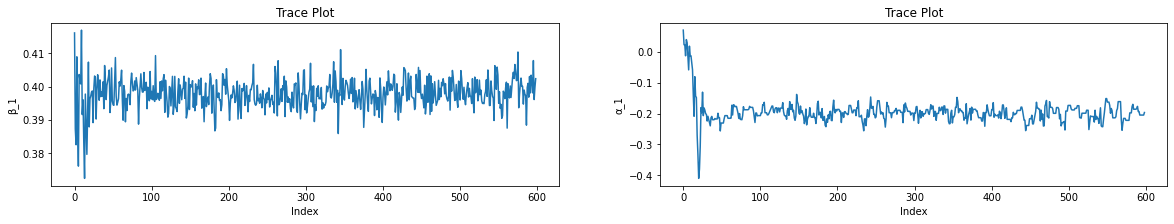

In [226]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 3))
p = 1
ax1.plot(gibbs_ind_ind.beta.values[1:, p])
ax1.set_xlabel("Index")
ax1.set_ylabel(f"β_{p+1}")
ax1.set_title("Trace Plot")

ax2.plot(gibbs_ind_ind.alpha.values[1:, p])
ax2.set_xlabel("Index")
ax2.set_ylabel(f"α_{p+1}")
ax2.set_title("Trace Plot")

fig.savefig("./figures/alpha_beta_plots.png")
plt.show()